In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

In [13]:
dat = np.load("CalibrationHitPattern.npz")

In [14]:
## fit the device parameters

def gain_fit(x,dg):
    return dg*x
    
def ca_fit(x,a):
    return a*x**2 


## gain vs ov
gdat = np.loadtxt('gain_vs_ov.txt', delimiter=',', skiprows=1)
gain_fit_vs_ov, bcov = curve_fit(gain_fit, gdat[:,0], gdat[:,1])
xx = np.linspace(0,8)
plt.figure()
#plt.plot(gdat[:,0], gdat[:,1], 'bo')
plt.plot(xx, gain_fit(xx, gain_fit_vs_ov), 'b')
plt.xlim(0,8)
plt.ylim(0, 6e6)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.savefig('gain_fit.png', transparent=True)
print("Fit to HPK gain [e/OV]: ", gain_fit_vs_ov)


## now the CA
cadat = np.loadtxt('ca_vs_ov.txt', delimiter=',', skiprows=1)
ca_fit_vs_ov, bcov = curve_fit(ca_fit, cadat[:,0], cadat[:,1])
xx = np.linspace(0,9)
plt.figure()
#plt.plot(cadat[:,0], cadat[:,1], 'bo')
plt.plot(xx, ca_fit(xx, *ca_fit_vs_ov), 'b')
plt.xlim(0,9)
plt.ylim(0, 3.5)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.savefig('ca_fit.png', transparent=True)
print("Fit to CA: ", ca_fit_vs_ov)

## now PDE
pdedat = np.loadtxt('pde_vs_ov.txt', delimiter=',', skiprows=1)
pde_fit = interp1d(pdedat[:,0], pdedat[:,1], fill_value="extrapolate", kind='quadratic')
xx = np.linspace(0,9)
plt.figure()
#plt.plot(pdedat[:,0], pdedat[:,1], 'bo')
plt.plot(xx, pde_fit(xx), 'b')
plt.xlim(0,9)
plt.ylim(5, 40)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.savefig('pde_fit.png', transparent=True)

plt.close('all')

Fit to HPK gain [e/OV]:  [735379.99731711]
Fit to CA:  [0.00883131]


In [15]:
x = dat['X']
y = dat['Y']
hp = dat['HitPattern']
print(np.shape(x))
print(np.shape(y))
print(np.shape(hp))

(41, 193)
(41, 193)
(192, 40)


In [16]:
### parameters for OV analysis:

scale_fac = 1 ## kludge for now to allow arbitrary scaling of counts -- eventually this should be set to 1
applied_OV = 4 ## Volts (intended) overvoltage
num_secs = 10 ## 10 s long file (10k events)
e_to_coul = 1.6e-19 ## coulombs per electron
r_bias = 100e6 ## Ohm

In [17]:
## now we have all the maps, we want to look at the energy reconstruction

event_dat = np.load("CenterTemplate.npy")
event_dat[np.isnan(event_dat)] = 0
center_shape = event_dat.T/np.sum(event_dat)
print(np.sum(event_dat))

189.0


In [29]:
def calculate_energy_scale(hp, center_shape, r_bias, num_sources, make_plots=False):

    num_adds = int(num_sources/4)
    #print(num_adds)

    orig_map = hp.T/(num_secs)

    nidx_to_roll = int(np.shape(orig_map)[1]/(num_adds*4))

    orig_map = orig_map[:,:-3]

    combined_map = np.zeros_like(orig_map)

    for i in range(0,num_adds):
        combined_map += np.roll(orig_map,nidx_to_roll*i, axis=1)/num_adds

    combined_map = np.hstack((combined_map, np.zeros((40,3))))

    photon_per_s_map = combined_map * scale_fac
    pe_per_s_map = photon_per_s_map * (1 + ca_fit(4, *ca_fit_vs_ov))
    ov_map = applied_OV/(1 + r_bias * gain_fit_vs_ov * pe_per_s_map * e_to_coul)

    gain_map = gain_fit(ov_map, gain_fit_vs_ov)
    pde_map = pde_fit(ov_map)
    ca_map = ca_fit(ov_map, *ca_fit_vs_ov)

    if(make_plots):
        plt.figure()
        plt.pcolormesh(x, y+130, pe_per_s_map, rasterized=True, vmin=0, vmax = 50000)
        plt.xlabel(r"Angular position, $\theta$ [rad]")
        plt.ylabel("Z position [mm]")
        plt.colorbar(label="Number of PE/s")
        plt.savefig("hit_location.pdf", dpi=300)

        plt.figure()
        plt.pcolormesh(ov_map, rasterized=True, vmin=2.5, vmax = 4) #, vmin=0, vmax=100000)
        plt.xlabel(r"Angular position, $\theta$ [rad]")
        plt.ylabel("Z position [mm]")
        plt.colorbar(label="Overvoltage (V)")
        plt.savefig("ov_location.pdf", dpi=300)

        plt.figure()
        plt.pcolormesh(gain_map, rasterized=True, vmin=1.5e6, vmax =2.9e6) #, vmin=0, vmax=100000)
        plt.xlabel(r"Angular position, $\theta$ [rad]")
        plt.ylabel("Z position [mm]")
        plt.colorbar(label="Gain [e/PE]")
        plt.savefig("gain_location.pdf", dpi=300)


        plt.figure()
        plt.pcolormesh(pde_map/100) #, vmin=0, vmax=100000)
        plt.colorbar()

        plt.figure()
        plt.pcolormesh(ca_map) #, vmin=0, vmax=100000)
        plt.colorbar()

    dbefore = np.sum(center_shape)
    dafter = np.sum(center_shape * gain_map/gain_fit(4, gain_fit_vs_ov) * pde_map/(pde_fit(4)) * (1 + ca_map)/(1 + ca_fit(4, *ca_fit_vs_ov)))

    dafter_gain_corr = np.sum(center_shape * pde_map/(pde_fit(4)) * (1 + ca_map)/(1 + ca_fit(4, *ca_fit_vs_ov)))


    return dafter, dafter_gain_corr


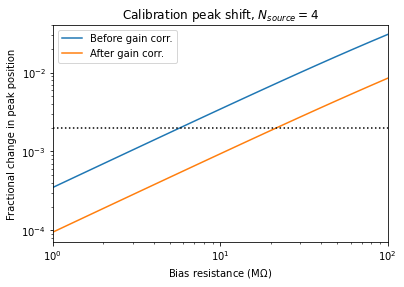

In [19]:
## plot of peak shift versus bias resistance

plt.figure()

r_values = np.logspace(6,8,20)
corr_mat_gain = np.zeros((len(r_values),2))

for n in [4]: #,8,16,32,64]:
    for i,r in enumerate(r_values):
        corr_mat_gain[i,:] = calculate_energy_scale(hp, center_shape, r, n, make_plots=False)

    plt.loglog(r_values/1e6, 1-corr_mat_gain[:,0], label="Before gain corr.")
    plt.loglog(r_values/1e6, 1-corr_mat_gain[:,1], label="After gain corr.")

plt.plot([1,1e2],[2e-3,2e-3], 'k:')
plt.xlim((1,1e2))
plt.xlabel("Bias resistance (M$\Omega$)")
plt.ylabel("Fractional change in peak position")
plt.title("Calibration peak shift, $N_{source} = 4$")
plt.legend(loc="upper left")
plt.savefig("shift_vs_num_rbias.pdf")

plt.show()

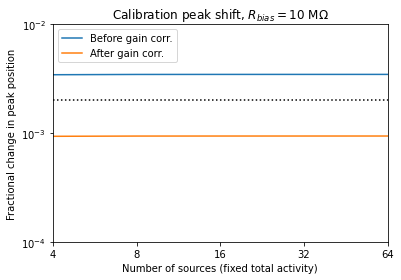

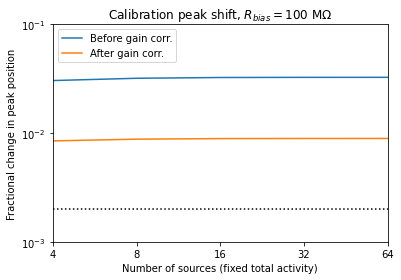

In [20]:
## plot of peak shift versus num sources



n_values = [4,8,16,32,64]

corr_mat_gain = np.zeros((len(n_values),2))

for r in [1e7, 1e8]:
    plt.figure()
    for i,n in enumerate(n_values):
        corr_mat_gain[i,:] = calculate_energy_scale(hp, center_shape, r, n, make_plots=False)

    plt.loglog(n_values, 1-corr_mat_gain[:,0], label="Before gain corr.")
    plt.loglog(n_values, 1-corr_mat_gain[:,1], label="After gain corr.")

    plt.gca().set_xticks(n_values)
    plt.minorticks_off()
    plt.gca().set_xticklabels(n_values)

    plt.plot([4,64],[2e-3,2e-3], 'k:')
    plt.xlim((4,64))
    if(r == 1e8):
        plt.ylim((1e-3,1e-1))
    else:
        plt.ylim((1e-4,1e-2)) 
    plt.xlabel("Number of sources (fixed total activity)")
    plt.ylabel("Fractional change in peak position")
    plt.title("Calibration peak shift, $R_{bias} =%d$ M$\Omega$"%(r/1e6))
    plt.legend(loc="upper left")
    plt.savefig("shift_vs_num_source_rb_%1e.pdf"%r)

plt.show()

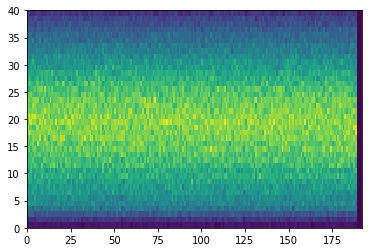

In [21]:
plt.figure()
plt.pcolormesh(center_shape)
plt.show()

0.03244681310935138 0.008898018194036794


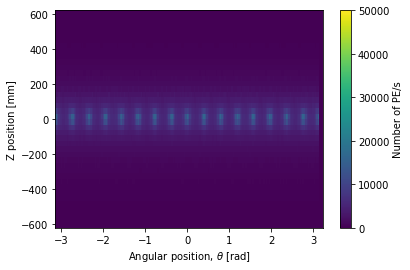

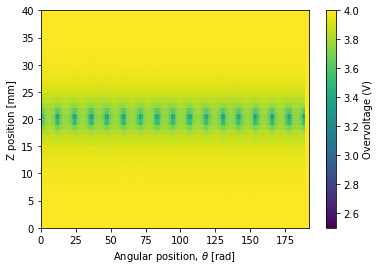

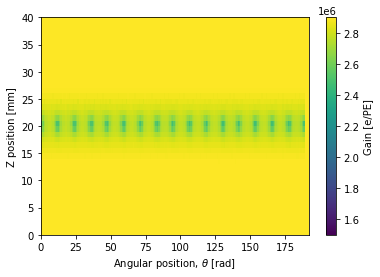

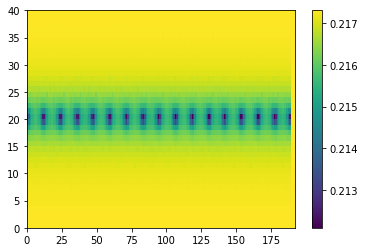

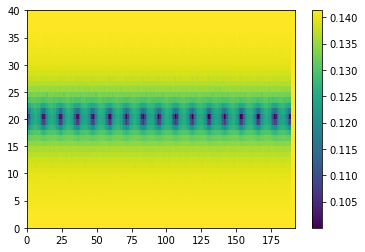

In [31]:
t = calculate_energy_scale(hp, center_shape, 1e8, 16, make_plots=True)
print(1-t[0], 1-t[1])

In [ ]:
dat = np.load("TestHitPattern.npz")

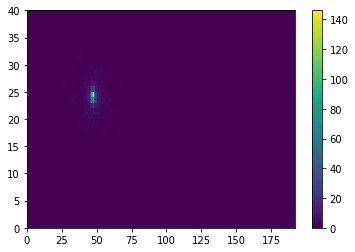

In [ ]:
plt.pcolormesh(dat['HitPattern'].T)
plt.colorbar()